In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
# --- Imports and Setup ---
import pandas as pd
import numpy as np
from numf import numf
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from numf.peaks import get_neighbors
from numf.utils import initialize_matrices

np.random.seed(42)

In [3]:
# --- File paths and run mode ---
INPUT_DATA = '../data/canada_regional_14d_avg.csv'
SAVED_OUTPUT_PATH = '../saved_output/14day_new'
RUN_ALGO = False  # Set to False to load saved results instead of running NuMF


In [4]:
# --- Utility functions ---
def load_saved_models(filepath):
    """Load W, H, pouts from a saved .npz file."""
    tmp = np.load(filepath)
    return tmp['W'], tmp['H'], tmp['pouts']

def plot_reg_graphs(M, base_mat, reg_mat):
    """
    Plot original, no-regularization, and regularized reconstructions
    with consistent y-axis scale and colors for the three subplots.
    """
    W, H = base_mat
    W_reg, H_reg = reg_mat
    r = W.shape[1]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

    # Gather all values to determine y-axis limits
    vals = [M.flatten(), (W @ H).flatten(), (W_reg @ H_reg).flatten()]
    for i in range(r):
        vals.append((W[:, i] * H[i, :]).flatten())
        vals.append((W_reg[:, i] * H_reg[i, :]).flatten())
    ymin = np.min(np.concatenate(vals))
    ymax = np.max(np.concatenate(vals))

    fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    # Plot original and reconstructions
    axs[0].plot(M, color='black', label='Original')
    axs[0].plot(W @ H, color='tab:blue', label='No Smoothing')
    axs[0].plot(W_reg @ H_reg, color='tab:orange', label='Smoothed')
    axs[0].legend()
    axs[0].set_title("Original vs Reconstructions")
    axs[0].set_ylim(ymin, ymax)

    # Plot W*H components (no reg)
    for i in range(r):
        axs[1].plot(W[:, i] * H[i, :], color=colors[i % len(colors)], label=f'W({i+1})*H({i+1})')
    axs[1].set_title('No Smoothing, W * H')
    axs[1].set_ylim(ymin, ymax)
    axs[1].legend()

    # Plot W*H components (reg)
    for i in range(r):
        axs[2].plot(W_reg[:, i] * H_reg[i, :], color=colors[i % len(colors)], label=f'W({i+1})*H({i+1})')
    axs[2].set_title('Smoothed, W * H')
    axs[2].set_ylim(ymin, ymax)
    axs[2].legend()

    plt.tight_layout()
    plt.show()


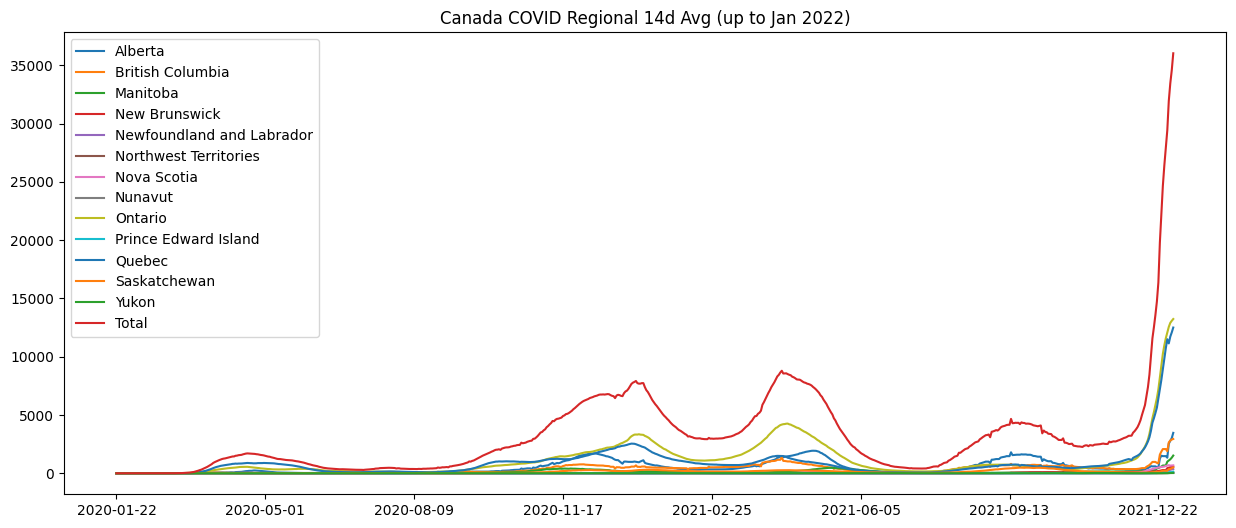

In [5]:
# --- Load and preprocess data ---
# Load the main dataset
df = pd.read_csv(INPUT_DATA, index_col=0)

# Limit to data up to 1 January 2022 (when Canada stopped widespread testing)
df_jan22 = df.loc[: '2022-01-01', :]
df_jan22.plot(title="Canada COVID Regional 14d Avg (up to Jan 2022)", figsize=(15, 6))

# --- Split the dataset into three periods (in memory) ---
split1 = df_jan22.loc[: '2020-08-15', :]
split2 = df_jan22.loc['2020-08-15': '2021-07-01', :]
split3 = df_jan22.loc['2021-07-01':, :]

splits = [
    ("split1", split1, 2),
    ("split2", split2, 3),
    ("split3", split3, 2),
]

In [6]:
iters = 200  # Number of iterations for all runs

Processing split1...


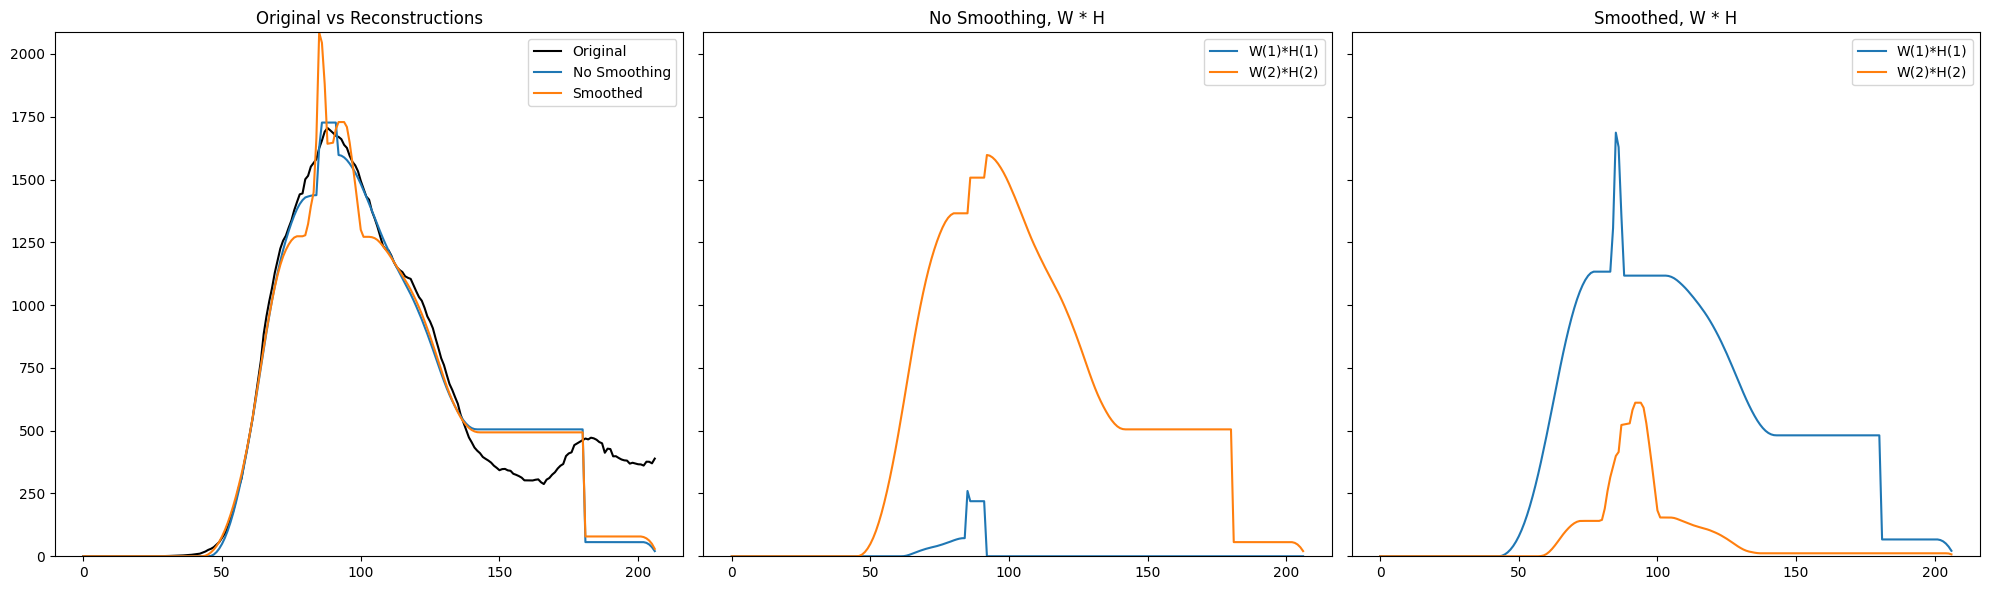

Processing split2...


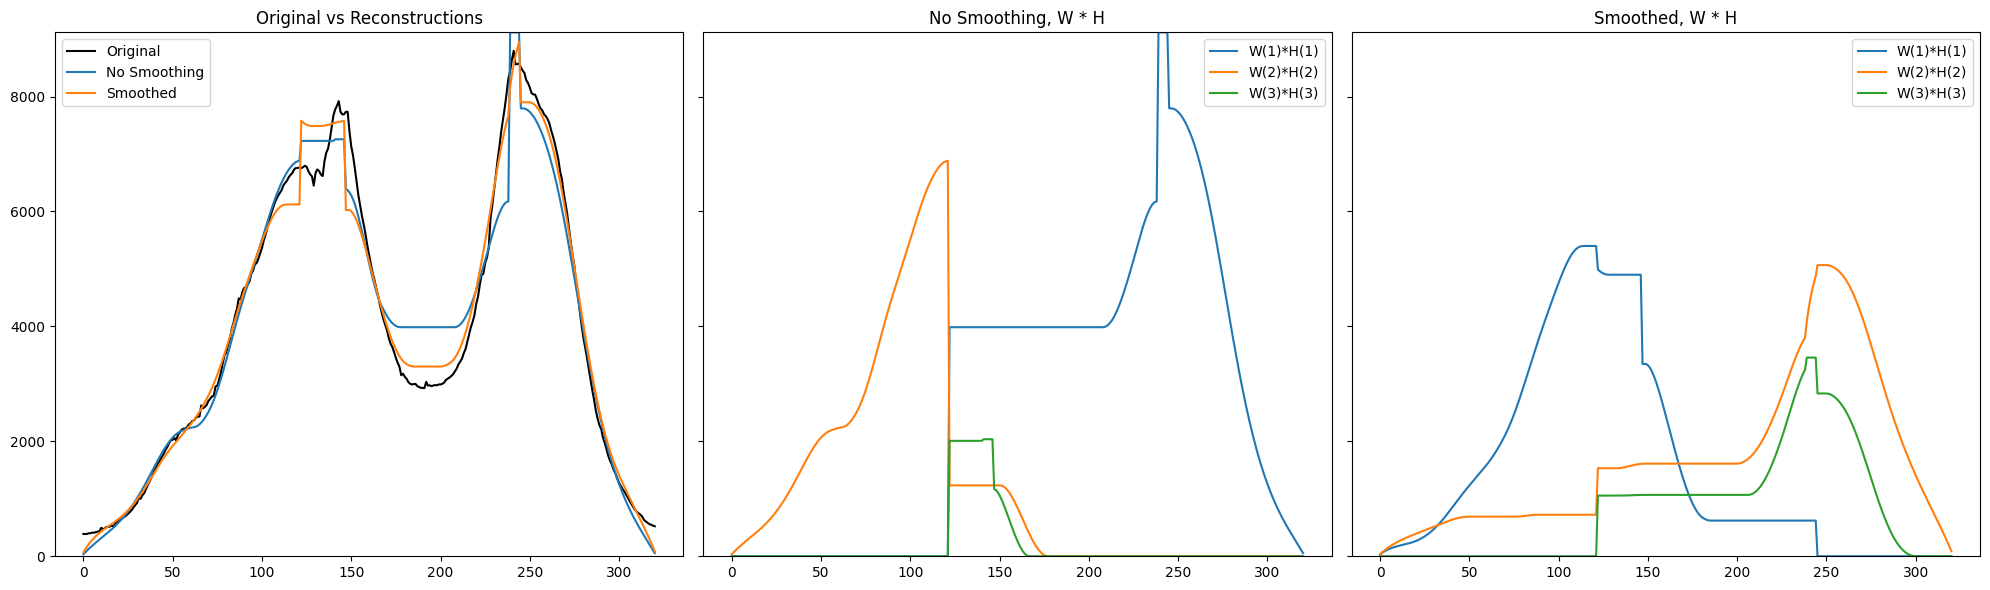

Processing split3...


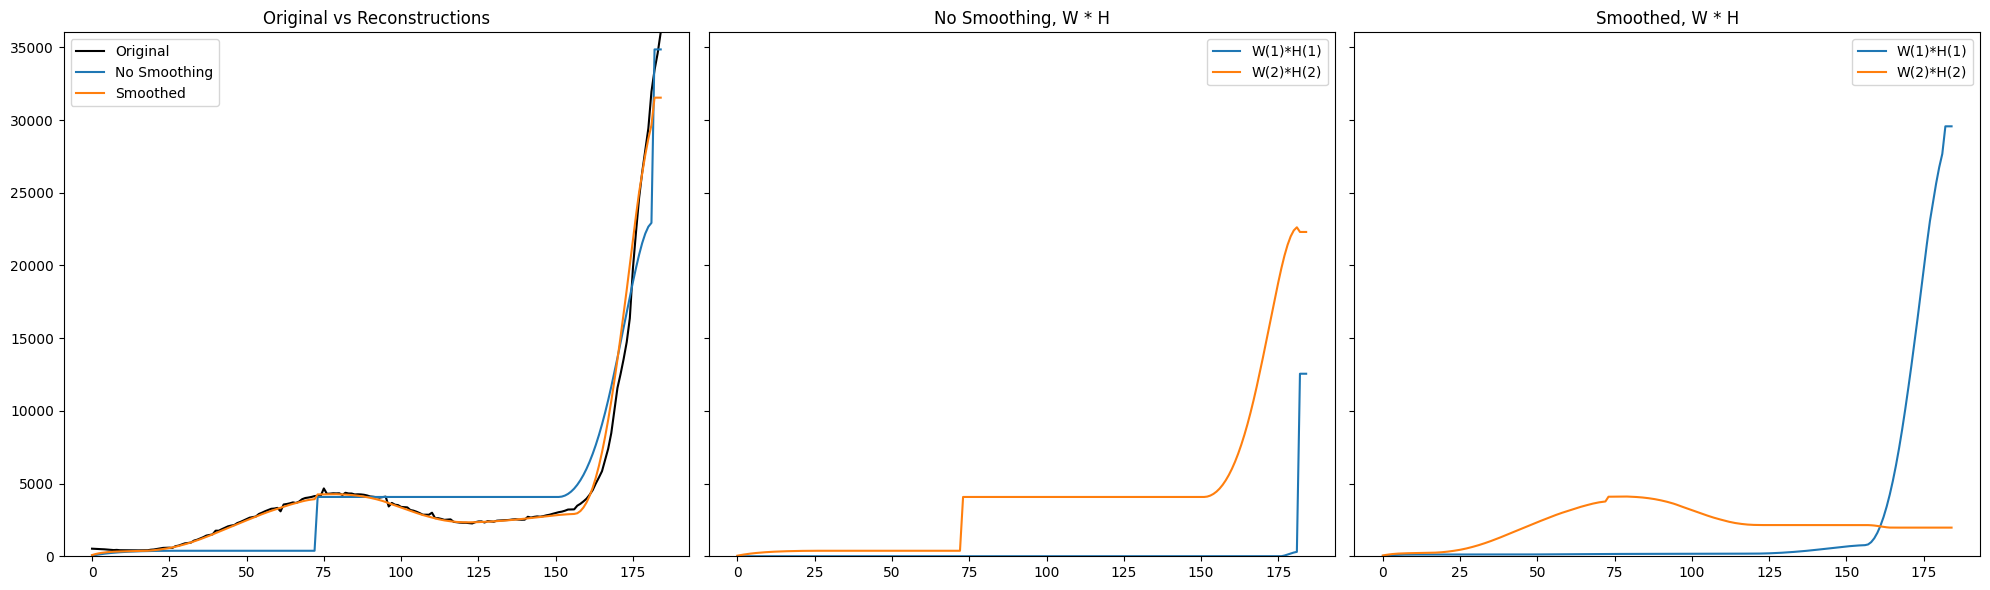

In [7]:
# --- Run NuMF for each split, with option to run or load ---
for split_name, df_split, rank in splits:
    print(f"Processing {split_name}...")
    M = df_split['Total'].to_numpy().reshape(-1, 1)
    m, n = M.shape

    # Find peaks and get neighborhood indices for unimodality constraints
    peaks, _ = find_peaks(x=df_split['Total'], prominence=1, width=6)
    if split_name == "split3":
        # For the last split, ensure the last index is included as a peak
        peaks = np.append(peaks, [df_split.shape[0] - 1])
    pvals = get_neighbors(peaks, m, nrad=3)

    # File paths for saving/loading results
    file_no_reg = f"{SAVED_OUTPUT_PATH}/{split_name}_it{iters}_no_reg.npz"
    file_reg = f"{SAVED_OUTPUT_PATH}/{split_name}_it{iters}_reg.npz"

    if RUN_ALGO:
        # --- Run NuMF without regularization ---
        W, H = initialize_matrices(m, n, r=rank)
        W, H, pouts = numf(M, W, H, pvals=pvals, iters=iters, save_file=file_no_reg, verbose=False)

        # --- Run NuMF with L2 regularization ---
        W_reg, H_reg = initialize_matrices(m, n, r=rank)
        W_reg, H_reg, pouts_reg = numf(M, W_reg, H_reg, pvals=pvals, l2=0.2, iters=iters, save_file=file_reg, verbose=False)
    else:
        # --- Load previously saved results ---
        W, H, _ = load_saved_models(file_no_reg)
        W_reg, H_reg, _ = load_saved_models(file_reg)

    # --- Plot results for this split ---
    plot_reg_graphs(M, (W, H), (W_reg, H_reg))


Processing complete dataset...


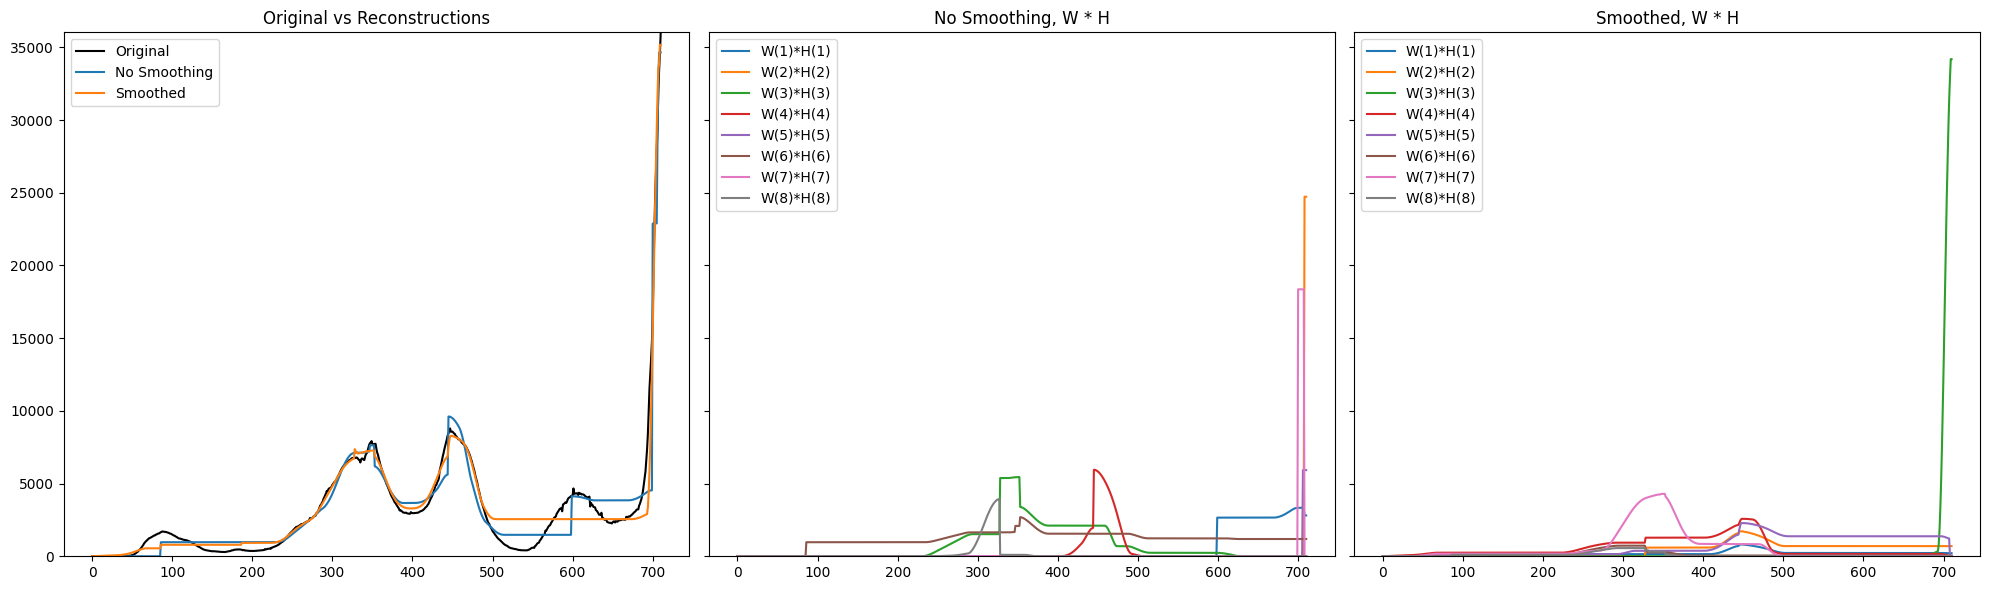

In [8]:
# --- Run NuMF on the complete dataset (up to Jan 2022) ---
print("Processing complete dataset...")
M_comp = df_jan22['Total'].to_numpy().reshape(-1, 1)
m, n = M_comp.shape
rank = 8

# Find peaks and get neighborhood indices for the full dataset
peaks, _ = find_peaks(x=df_jan22['Total'], prominence=1, width=6)
peaks = np.append(peaks, [df_jan22.shape[0] - 1])
pvals = get_neighbors(peaks, m, nrad=3)

file_no_reg = f"{SAVED_OUTPUT_PATH}/comp_it{iters}_no_reg.npz"
file_reg = f"{SAVED_OUTPUT_PATH}/comp_it{iters}_reg.npz"

if RUN_ALGO:
    # --- Run NuMF without regularization ---
    W_comp, H_comp = initialize_matrices(m, n, r=rank)
    W_comp, H_comp, _ = numf(M_comp, W_comp, H_comp, pvals=pvals, iters=iters, save_file=file_no_reg, verbose=False)

    # --- Run NuMF with L2 regularization ---
    W_reg, H_reg = initialize_matrices(m, n, r=rank)
    W_reg, H_reg, _ = numf(M_comp, W_reg, H_reg, pvals=pvals, l2=0.2, iters=iters, save_file=file_reg, verbose=False)
else:
    # --- Load previously saved results ---
    W_comp, H_comp, _ = load_saved_models(file_no_reg)
    W_reg, H_reg, _ = load_saved_models(file_reg)

# --- Plot results for the complete dataset ---
plot_reg_graphs(M_comp, (W_comp, H_comp), (W_reg, H_reg))